In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm


In [2]:
def Mape(predicted_values,true_values):
    # Calculate MAPE for train data
    return np.mean(np.abs((predicted_values - true_values) / true_values)*100)

In [3]:
def Bias(predicted_values,true_values):
   return np.mean(predicted_values-true_values)

In [4]:
def Dw_Pvalue(model_fit):
    # Calculate Durbin-Watson p-value
    dw_test = sm.stats.stattools.durbin_watson(model_fit.resid)
    dw_p_value=2*(1-norm.cdf(abs(dw_test)))
    return dw_p_value

In [5]:
def Lb_Pvalue(model_fit):
    # Perform the Ljung-Box test
    lb_test = sm.stats.acorr_ljungbox(model_fit.resid)
    ar1=np.array(lb_test['lb_pvalue'])
    return ar1[0]

In [6]:
def CoV(data):
    cv = np.std(data['Quantity']) / np.mean(data['Quantity'])
    return cv


In [7]:
def Rmse(forecast,truevalues):
    return np.sqrt(mean_squared_error(truevalues, forecast))

In [8]:
def Accuracy(rmse,truevalues):
    return (100 - (rmse / np.mean(truevalues) * 100))

In [9]:
def Trend_comp(past1year_observation,next1year_forecast):
    return (np.mean(past1year_observation))/(np.mean(next1year_forecast))

In [10]:
def mase(train_data,test_data,forecast):
    
    naive_forecast = train_data.iloc[-1]

    # Repeat the naive forecast for the length of the test data
    naive_forecast = np.repeat(naive_forecast, len(test_data))

    # Calculate the mean absolute error (MAE)
    naive_mae = mean_absolute_error(test_data, naive_forecast)
    mae_model = mean_absolute_error(test_data,forecast)
    
    return (mae_model/naive_mae)

In [11]:
def ACF_estimate_p_q(data):
    # Calculate ACF and PACF
    
    len1=len(data)/2-1
    max_lags=min(len1,15)

    acf_values = sm.tsa.stattools.acf(data, nlags=max_lags)
    pacf_values = sm.tsa.stattools.pacf(data, nlags=max_lags)
    

    # Find the significant lags based on ACF and PACF plots
    q = np.where(acf_values > 0.2)[0][-1]
    p = np.where(pacf_values > 0.2)[0][-1]
    
    return p, q

In [12]:
def best_arima(data,sku):
    
    if (len(data))>24:
        test_size=12
    else:
        test_size=6

    train_data=data
    test_data=data[-test_size:]
    
    result = adfuller(data['Quantity'])

    # Extract ADF test statistics
    adf_stat = result[0]
    p_value = result[1]

    # Define significance level
    alpha = 0.05

    # Check if the series is stationary or not
    if p_value < alpha:
        d1=0
        d2=1
    else:
        d1 = 1
        d2=2
        
    # Define the parameter ranges for p, d, q, P, D, Q
    p_values = range(1, 7)
    d_values = range(d1,d2)
    q_values = range(1, 7)

    best_rmse = float('inf')  # Initialize best RMSE with a high value
    best_model = None
    best_p, best_d, best_q = None, None, None

    # Perform grid search
    for p, d, q in product(p_values, d_values, q_values):
        try:
            model = ARIMA(train_data['Quantity'], order=(p, d, q))
            model_fit = model.fit()

            # Forecast the data
            forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

            # Calculate RMSE
            low_rmse = Rmse(forecast,test_data['Quantity'])

            if low_rmse < best_rmse:
                best_model = model_fit
                best_rmse = low_rmse
                best_p, best_d, best_q = p, d, q
        except:
            continue

    acf_p,acf_q=ACF_estimate_p_q(data['Quantity'])
    print("Estimate of p and q from acf plots",acf_p,acf_q)

    for d in range(d1,d2):

        acf_model = ARIMA(train_data['Quantity'], order=(acf_p, d, acf_q))
        acf_model_fit = acf_model.fit()

        # Forecast the data
        acf_forecast = acf_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

        # Calculate RMSE
        acf_rmse = Rmse(acf_forecast,test_data['Quantity'])
        
        if acf_rmse < best_rmse:
            best_model = acf_model_fit
            best_rmse = acf_rmse
            best_p, best_d, best_q = acf_p, d, acf_q


            
    final_order=[best_p, best_d, best_q]
    print("FinalOrder",final_order)

    # Forecast the data
    forecast = best_model.predict(start=test_data.index[0], end=test_data.index[-1])
    future_forecast = best_model.forecast(steps=25)
    
    # Calculate accuracy

    best_rmse=Rmse(forecast,test_data['Quantity'])
    train_rmse=Rmse(best_model.fittedvalues,train_data['Quantity'])
    train_accuracy = Accuracy(train_rmse,data['Quantity'])
    test_accuracy = Accuracy(best_rmse,test_data['Quantity'])

    mape_train=Mape(best_model.fittedvalues,train_data['Quantity'])
    mape_test=Mape(forecast,test_data['Quantity'])
    bias_test=Bias(forecast,test_data['Quantity'])
    bias_train=Bias(best_model.fittedvalues,data['Quantity'])
    dwpvalue1=Dw_Pvalue(best_model)
    lbpvalue1=Lb_Pvalue(best_model)
    cov=CoV(data)
    MASE1=mase(train_data['Quantity'],test_data['Quantity'],forecast)
    trend_compare=Trend_comp(test_data['Quantity'],future_forecast[:test_size-1])

    print("SKU:", sku)
    
    # Print the accuracy
    print("test_Accuracy:", test_accuracy)
    print("train_Accuracy:", train_accuracy)
    print("Best_RMSE" , best_rmse)
    print("Train_RMSE",train_rmse)
    print("Mape_Train",Mape(best_model.fittedvalues,train_data['Quantity']))
    print("Mape_test",Mape(forecast,test_data['Quantity']))
    print("DW_Pvalue",Dw_Pvalue(best_model))
    print("Bias-Train",Bias(best_model.fittedvalues,data['Quantity']))
    print("Bias-Test",Bias(forecast,test_data['Quantity']))
    print("LB_Pvalue",Lb_Pvalue(best_model))
    print("Coefficient of variation",CoV(data))
    print("Mase", mase(train_data['Quantity'],test_data['Quantity'],forecast))
    print("Trend Comparison", Trend_comp(test_data['Quantity'],future_forecast[:test_size-1]))
    
    # Plot the forecasted data
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Quantity'], label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast')
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('ARIMA Forecast - SKU: ' + str(sku))
    plt.legend()
    plt.show()


C:\Users\p90014646\AppData\Local\Temp\ipykernel_11680\638024098.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sku_data["Date"] = pd.to_datetime(sku_data["Date"])
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informati

SKU: 300000845


c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\bas

Estimate of p and q from acf plots 12 0
FinalOrder [5, 0, 6]
SKU: 300000845
test_Accuracy: 67.42059658204103
train_Accuracy: 61.252392804498406
Best_RMSE 2663.8956447236874
Train_RMSE 2863.086527413743
Mape_Train 59.05610024896635
Mape_test 44.02775860768821
DW_Pvalue 0.04994639012727209
Bias-Train 409.27035471539045
Bias-Test -686.4081418496111
LB_Pvalue 0.9536184917966867
Coefficient of variation 0.47611423562597427
Mase 0.37585389530172014
Trend Comparison 1.1276518002612617


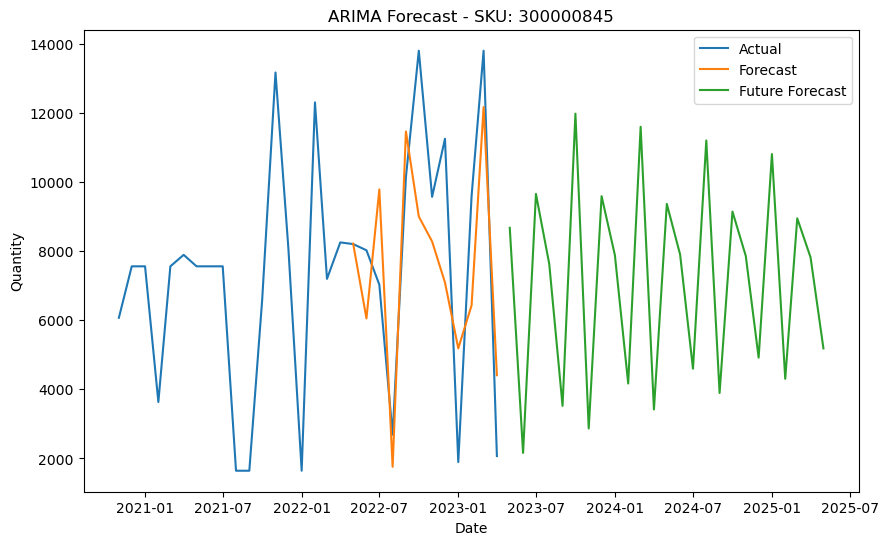


SKU: 300034265


C:\Users\p90014646\AppData\Local\Temp\ipykernel_11680\638024098.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sku_data["Date"] = pd.to_datetime(sku_data["Date"])
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informati

Estimate of p and q from acf plots 15 15
FinalOrder [5, 0, 6]
SKU: 300034265
test_Accuracy: 42.782241724623525
train_Accuracy: 56.64370600121081
Best_RMSE 4767.431300969598
Train_RMSE 6446.136849341742
Mape_Train 4617.382879167125
Mape_test 64.37357694658527
DW_Pvalue 0.05134378069969325
Bias-Train 414.1809204168175
Bias-Test 27.909121886506
LB_Pvalue 0.8332256017712083
Coefficient of variation 0.5549277039982082
Mase 0.8079481617703366
Trend Comparison 0.8683111919550821


c:\Users\p90014646\.conda\envs\SKU_Forecast\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


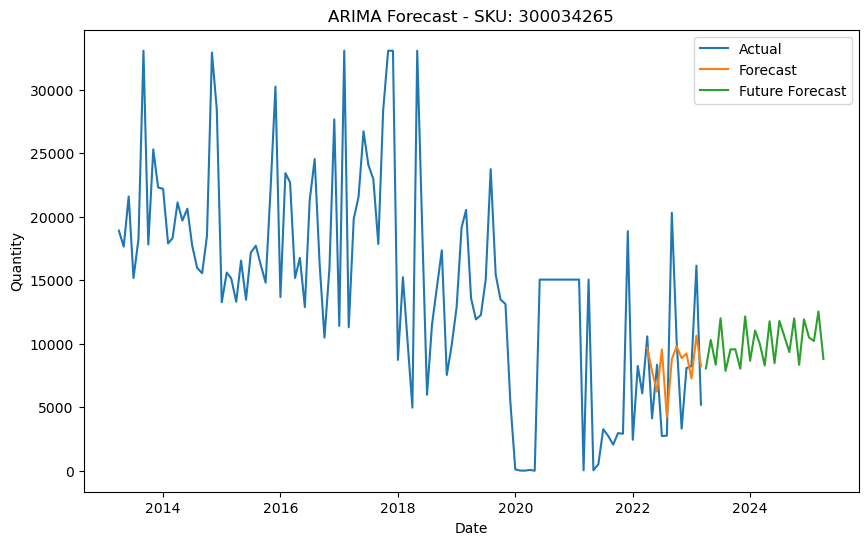

In [13]:
    
data=pd.read_csv('./../Cleaning/cleaned_data_2.csv')

# Convert the "Date" column to datetime format
data["Date"] = pd.to_datetime(data["Date"], format="%d-%m-%Y")

# Convert the "Date" column back to string format with "mm-dd-yyyy" format
data["Date"] = data["Date"].dt.strftime("%m-%d-%Y")

# Get unique SKU numbers from the dataset
sku_numbers = data['SKU'].unique()

# Iterate over each SKU number
for sku in sku_numbers:
    sku_data = data[data['SKU'] == sku]
    sku_data["Date"] = pd.to_datetime(sku_data["Date"])
    sku_data.set_index('Date',inplace=True)
    print("SKU:", sku)
    best_arima(sku_data, sku)
    print()